In [1]:
import argparse
import cv2
import re
import matplotlib.pyplot as plt

parser = argparse.ArgumentParser(description='RNN-CNN Network.')
parser.add_argument('--gpu', default=3, help='GPU to use for train')
parser.add_argument('--name', default="cats_vs_dogs_model", help='Name of the RNN model to use for train')
args, unknown_args = parser.parse_known_args()

In [2]:
import tensorflow as tf
import numpy as np
from scipy.misc import imread, imresize
from os import listdir, environ
import pandas as pd
from IPython import embed
import sys
import random
import time
import os

from datasets import flowers
from nets import inception
from preprocessing import inception_preprocessing

from datasets import dataset_utils

slim = tf.contrib.slim

BEST_ACC = 0
CHECKPOINTS_DIR = "checkpoints/"

class InceptionV4:
    def __init__(self, model_name, isTesting=False):
        tf.reset_default_graph()
        
        self.X = tf.placeholder(tf.float32, shape=[None, 299,299,3])
        self.y = tf.placeholder(tf.float32, shape=[None, 2])
        
        self.X_preproc = tf.map_fn(lambda image: inception_preprocessing.preprocess_image(image, 299, 299), self.X)

        self.name = model_name
        
        self.__model()
        
        self.saver = tf.train.Saver()

        # Just in case a previous run was closed using a halt file.
        if os.path.isfile("{}.halt".format(self.name)):
            os.remove("{}.halt".format(self.name))

        # if weights is not None and sess is not None:
        #     self.load_weights(sess, weights)
    
    def __get_init_fn(self):
        """Returns a function run by the chief worker to warm-start the training."""
        checkpoint_exclude_scopes=["InceptionV4/Logits", "InceptionV4/AuxLogits"]

        exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

        variables_to_restore = []
        for var in slim.get_model_variables():
            excluded = False
            for exclusion in exclusions:
                if var.op.name.startswith(exclusion):
                    excluded = True
                    break
            if not excluded:
                variables_to_restore.append(var)

        return slim.assign_from_checkpoint_fn(
          os.path.join(CHECKPOINTS_DIR, 'inception_v4.ckpt'),
          variables_to_restore)
        
    def __model(self):
        self.image_size = inception.inception_v4.default_image_size

        # Create the model, use the default arg scope to configure the batch norm parameters.
        with slim.arg_scope(inception.inception_v4_arg_scope()):
            self.logits, self.end_points = inception.inception_v4(self.X_preproc, num_classes=2, is_training=False)

        # Specify the loss function:
#         slim.losses.softmax_cross_entropy(self.logits, self.y)
#         self.total_loss = slim.losses.get_total_loss()
        self.total_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(self.logits, self.y))
        
        self.probs = self.end_points["Predictions"]

        # Calculate Accuracy
        self.correct_prediction = tf.equal(tf.argmax(self.probs, 1), tf.argmax(self.y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # Specify the optimizer and create the train op:
        self.optimizer = tf.train.AdamOptimizer(epsilon=0.1)
        self.train_step = slim.learning.create_train_op(self.total_loss, self.optimizer)

        self.init_fn = self.__get_init_fn()

    def __iterate_minibatches(self, X,y, size):
        if X.shape[0] % size > 0:
            raise "The minibatch size should be a divisor of the batch size."

        idx = np.arange(X.shape[0])
        np.random.shuffle(idx) # in-place shuffling
        for i in range(X.shape[0] / size):
            # To randomize the minibatches every time
            _idx = idx[i*size:(i+1)*size]
            yield X[_idx], y[_idx]

    def __update_screen(self, msg):
        sys.stdout.write(msg)
        sys.stdout.flush()

    def resize_images(self, X):
        return np.array([ imresize(X[i], (299,299)) for i in range(X.shape[0])])
    
    def generate_base_features(self, sess, Xt, prefix="X", size=1000, step=50):
        images = []
        sample_idx = range(0, size)
        for i in range(size / step):
            [image] = sess.run([self.end_points['PreLogitsFlatten']], feed_dict={self.X: Xt[sample_idx[i*step:(i+1)*step]] })
            images.append(image)
            self.__update_screen("\r{} out of {}".format(i, size/step))

        images = np.vstack(images)
        np.save("inception_catdogs/{}.npy".format(prefix), images)
        return images
    
    def calculate_loss(self, sess, Xt, yt, size=1000, step=10):
        fc3ls = None
        sample_idx = random.sample(range(0, Xt.shape[0]), size)
        for i in range(size / step):
            [fc3l] = sess.run([self.logits], feed_dict={self.X: Xt[sample_idx[i*step:(i+1)*step]], self.y: yt[sample_idx[i*step:(i+1)*step]]})
            if i == 0:
                fc3ls = fc3l
            else:
                fc3ls = np.vstack((fc3ls, fc3l))

        loss, accuracy = sess.run([self.total_loss, self.accuracy], feed_dict={self.logits: fc3ls, self.y: yt[sample_idx]})

        return loss, accuracy

    def __graceful_halt(self, t_start_training):
        # Save Trained Model
        p = self.saver.save(sess, "{}.tfmodel".format(self.name))
        t = time.time() - t_start_training
        print("++ Training: END -- Exec. Time={0:.0f}m {1:.0f}s Model Path={2:s}".format(t / 60, t % 60, p))


    def train(self, sess, X, y, val_X, val_y, epochs=30, minibatch_size=500, optimizer=None):
        print("++ Training with {} epochs and {} minibatch size.".format(epochs, minibatch_size))
        
        BEST_ACC = 0
        
        if optimizer is not None:
            self.optimizer = optimizer
        
        # Initialize Model ...
        sess.run(tf.initialize_all_variables())
        self.init_fn(sess)
        
        # Resize Validation Once ...
        val_X_res = self.resize_images(val_X)

        t_start_training = time.time()
        for i in range(epochs):
            t_start_epoch = time.time()
            t_start_minibatch = time.time()
            print("+++ Epoch 1: START")
            cnt = 0
            for _X, _y in self.__iterate_minibatches(X, y, minibatch_size):
                # Resize Training Batches (to avoid consuming much memeory)
                cnt += 1
                _X_res = self.resize_images(_X)
                self.__update_screen("\r++++ Mini Batch ({} out of {}): ".format(cnt, X.shape[0]/minibatch_size))
                sess.run([self.train_step], feed_dict={vgg.X: _X_res, vgg.y: _y})
                if cnt % 25 == 0:
                    # loss, accuracy = sess.run([self.cross_entropy, self.accuracy], feed_dict={self.X: val_X_res[test_sample], self.y: val_y[test_sample]})
                    val_loss, val_accuracy = self.calculate_loss(sess, val_X_res, val_y, 1000)
                    t = time.time() - t_start_minibatch
                    self.__update_screen(" Loss={0:.4f} Accuracy={1:.4f} Exec. Time={2:.0f}m {3:.0f}s\n".format(val_loss, val_accuracy, t / 60, t % 60))
                    t_start_minibatch = time.time()

                    # Handle Close Signals
                    if os.path.isfile("{}.halt".format(self.name)):
                        self.__graceful_halt(t_start_training)
                        os.remove("{}.halt".format(self.name))
                        exit(0)

            self.__update_screen("\n")
            val_loss, val_accuracy = self.calculate_loss(sess, val_X_res, val_y, val_X.shape[0])
            t = time.time() - t_start_epoch
            print("+++ Epoch {0:.0f}: END -- Loss={1:.4f} Accuracy={2:.4f} Exec. Time={3:.0f}m {4:.0f}s".format(i, val_loss, val_accuracy, t / 60, t % 60))

            # Always Save Best Accuracy
            if val_accuracy > BEST_ACC:
                BEST_ACC = val_accuracy
                self.saver.save(sess, "{}.tfmodel".format(self.name))
                print("+++ Epoch {0:.0f}: END -- SAVED BEST ACC".format(i))

        self.__graceful_halt(t_start_training)


    def predict(self, sess, X):
        prob = sess.run(vgg.probs, feed_dict={vgg.X: [X]})[0]
        preds = (np.argsort(prob)[::-1])[0:5]
        for p in preds:
            print p, prob[p]



    def load_weights(self, sess, weight_file):
        # This includes optimizer variables as well.
        init = tf.initialize_all_variables()
        sess.run(init)

        weights = np.load(weight_file)
        keys = sorted(weights.keys())
        for i, k in enumerate(keys):
            if i == 30:
                break
            print i, k, np.shape(weights[k])
            sess.run(self.parameters[i].assign(weights[k]))

        # Transfer Learning
        # Initialize the last fully connected layer
        for par in self.parameters[-2:]:
            print("Param: {}".format(par.name))

In [3]:
def update_screen(msg):
    sys.stdout.write(msg)
    sys.stdout.flush()

In [4]:
def prepare_data():
    TRAIN_DIR = '/home/devyhia/cats.vs.dogs/train/'
    TEST_DIR = '/home/devyhia/cats.vs.dogs/test/'

    ROWS = 299
    COLS = 299
    CHANNELS = 3
    SLICE = 10000

    train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
    train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
    train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

    # test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


    # slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
#     train_images = train_dogs[:SLICE] + train_cats[:SLICE]
#     valid_images = train_dogs[SLICE:] + train_cats[SLICE:]

#     np.random.shuffle(train_images)
#     np.random.shuffle(valid_images)

    def read_image(file_path):
        img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
        return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


    def prep_data(images):
        count = len(images)
        data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

        for i, image_file in enumerate(images):
            data[i] = read_image(image_file).astype(np.float32)
            if i%250 == 0: update_screen('\rProcessed {} of {}'.format(i, count))
        
        update_screen('\n')

        return data

    def get_label(path):
        return 1 if re.search("(cat|dog)\.(\d+)\.", path).group(1) == 'cat' else 0
    
    print("Prep data ...")
    X = prep_data(train_images)
#     Xt = prep_data(valid_images)
    # test = prep_data(test_images)
    
#     pre_processing = tf.placeholder(tf.float32, shape=[None, 299,299,3])
#     after_processing = tf.sub(tf.mul(pre_processing, 2.0/255.), 1.0)
    
#     def preprocess(sess, X, i, batch_size):
#         update_screen("\rPreprocessing {} ...".format(i))
#         return sess.run(after_processing, feed_dict={pre_processing: X[i*batch_size:(i+1)*batch_size]})
    
#     with tf.Session() as sess:
#         Xs, Xts = [], []
#         batch_size = 200
        
#         for i in range(X.shape[0] / batch_size):
#             Xs.append(preprocess(sess, X, i, batch_size))
#         update_screen("\n")
        
#         for i in range(Xt.shape[0] / batch_size):
#             Xts.append(preprocess(sess, Xt, i, batch_size))
#         update_screen("\n")
        
#         X = np.vstack(Xs)
#         Xt = np.vstack(Xts)
        
    print("Train shape: {}".format(X.shape))
#     print("Valid shape: {}".format(Xt.shape))

    labels_train = [get_label(i) for i in train_images]
#     labels_valid = [get_label(i) for i in valid_images]

    print(pd.DataFrame(labels_train, columns=["label"])["label"].value_counts())
#     print(pd.DataFrame(labels_valid, columns=["label"])["label"].value_counts())

    y = np.zeros((X.shape[0], 2))
#     yt = np.zeros((Xt.shape[0], 2))

    for i in range(y.shape[0]):
        y[i, labels_train[i]] = 1

#     for i in range(yt.shape[0]):
#         yt[i, labels_valid[i]] = 1

    # print(labels_train)
    # print(labels_valid)

    print(y)
#     print(yt)

    print("X=", X.shape, "y=", y.shape)
#     print("Xt=", Xt.shape, "yt=", yt.shape)

    return X, y


def prepare_test_data():
    CACHE_PATH = "cache/Xt.npy"
    if os.path.isfile(CACHE_PATH):
        data = np.load(CACHE_PATH)
        return range(1, data.shape[0]+1), data

    TEST_DIR = '/home/devyhia/cats.vs.dogs/test/'

    ROWS = 299
    COLS = 299
    CHANNELS = 3

    file_key = lambda f: int(re.match("(\d+)\.jpg", f).group(1))
    test_images =  [TEST_DIR+i for i in sorted(os.listdir(TEST_DIR), key=file_key)]

    def read_image(file_path):
        img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
        return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


    def prep_data(images):
        count = len(images)
        data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)
        ids = []

        for i, image_file in enumerate(images):
            data[i] = read_image(image_file)
            ids.append(re.search("(\d+)\.", image_file).group(1))

            if i%250 == 0: update_screen('\rProcessed {} of {}'.format(i, count))
        
        update_screen('\n')
        
        return ids, data

    ids, data = prep_data(test_images)

    np.save(CACHE_PATH, data)

    return ids, data

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu)

DATA_DIR = "/home/devyhia/vgg/"

model_name = args.name
vgg = InceptionV4(model_name)

sess = tf.Session()

In [6]:
# tinyImageNetDir = "/home/devyhia/vgg"
# X, y = np.load("{}/X.npy".format(tinyImageNetDir)), np.load("{}/y.npy".format(tinyImageNetDir))
# Xt, yt = np.load("{}/Xt.npy".format(tinyImageNetDir)), np.load("{}/yt.npy".format(tinyImageNetDir))
X, y = prepare_data()

Prep data ...
Processed 24750 of 25000
Train shape: (25000, 299, 299, 3)
1    12500
0    12500
Name: label, dtype: int64
[[ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 ..., 
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]
('X=', (25000, 299, 299, 3), 'y=', (25000, 2))


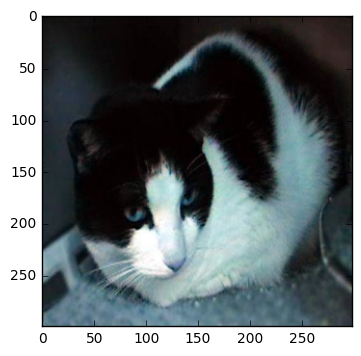

In [21]:
plt.imshow(X[6])

In [54]:
ids, Xt = prepare_test_data()

Processed 12250 of 12500


In [22]:
# Initialize Model ...
# sess.run(tf.initialize_all_variables())
vgg.init_fn(sess)

In [ ]:
images = vgg.generate_base_features(sess, X, size=X.shape[0], prefix='X')

54 out of 500

In [28]:
np.save("inception_catdogs/y.npy", y)

In [55]:
vgg.generate_base_features(sess, Xt, size=Xt.shape[0], prefix='Xt')

249 out of 250

In [49]:
assert map(lambda x: int(x), ids) == sorted(map(lambda x: int(x), ids))

## Fully Connected

In [29]:
with tf.name_scope("FullyConnected") as sc:
    X = tf.placeholder(tf.float32, shape=[None, images.shape[1]], name="X")
    Y = tf.placeholder(tf.float32, shape=[None, 2], name="Y")

    net = slim.stack(X, slim.fully_connected, [1000, 2], scope='fc', reuse=True)
    probs = tf.nn.softmax(net)

    with tf.name_scope("cost"):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(net, Y))
        train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
        # Add scalar summary for cost
        tf.scalar_summary("cost", cost)

    with tf.name_scope("accuracy"):
        correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(probs, 1)) # Count correct predictions
        acc_op = tf.reduce_mean(tf.cast(correct_pred, "float")) # Cast boolean to float to average
        # Add scalar summary for accuracy
        tf.scalar_summary("accuracy", acc_op)

ValueError: Trying to share variable fc/fc_1/weights, but specified shape (1536, 1000) and found shape (1536, 32).

In [ ]:
with tf.Session() as sess:
    # create a log writer. run 'tensorboard --logdir=./logs/nn_logs'
    writer = tf.train.SummaryWriter("logs/nn_logs", sess.graph) # for 0.8
    merged = tf.merge_all_summaries()

    # you need to initialize all variables
    tf.initialize_all_variables().run()

    for i in range(100):
        for start, end in zip(range(0, images.shape[0], 100), range(100, images.shape[0]+1, 100)):
            sess.run(train_op, feed_dict={X: images[start:end], Y: y[start:end]})
        summary, acc = sess.run([merged, acc_op], feed_dict={X: images[:1000], Y: y[:1000]})
        writer.add_summary(summary, i)  # Write summary
        print(i, acc)                   # Report the accuracy